<a href="https://colab.research.google.com/github/fvillarino/ITBA-CNN/blob/main/CIFAR10-CNN-tipoVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'


In [ ]:
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Keras modules

In [24]:
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Dropout, MaxPooling2D

## Cargo datos

In [4]:
from keras.datasets import cifar10
((x, y), (x_test,y_test)) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

## Paso a float

In [6]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

In [7]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

## Red neuronal: CNN tipo VGG-11

In [8]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=(32,32,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          1

In [9]:
# Callbacks
checkpoint_file='checkpoint.cifar10-cnn-tipo-VGG-16.hdf5'
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=2)
checkpointer = ModelCheckpoint(monitor='val_accuracy',filepath=checkpoint_file, verbose=1, save_best_only=True)

In [10]:
x_train.shape

(45000, 32, 32, 3)

In [11]:
y_train_categorical.shape

(45000, 10)

In [12]:
batch_size = 64
epocs = 100

history = model.fit(x_train, 
        y_train_categorical,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_valid, y_val_categorical),
        callbacks=[checkpointer, earlystop],
    )

Epoch 1/100
704/704 [==============================] - 37s 6ms/step - loss: 1.9678 - accuracy: 0.2447 - val_loss: 1.3275 - val_accuracy: 0.5210

Epoch 00001: val_accuracy improved from -inf to 0.52100, saving model to checkpoint.cifar10-cnn-tipo-VGG-16.hdf5
Epoch 2/100
704/704 [==============================] - 4s 5ms/step - loss: 1.3432 - accuracy: 0.5165 - val_loss: 1.2823 - val_accuracy: 0.5512

Epoch 00002: val_accuracy improved from 0.52100 to 0.55120, saving model to checkpoint.cifar10-cnn-tipo-VGG-16.hdf5
Epoch 3/100
704/704 [==============================] - 4s 5ms/step - loss: 1.1682 - accuracy: 0.5899 - val_loss: 1.0444 - val_accuracy: 0.6326

Epoch 00003: val_accuracy improved from 0.55120 to 0.63260, saving model to checkpoint.cifar10-cnn-tipo-VGG-16.hdf5
Epoch 4/100
704/704 [==============================] - 4s 5ms/step - loss: 1.0108 - accuracy: 0.6497 - val_loss: 0.9565 - val_accuracy: 0.6634

Epoch 00004: val_accuracy improved from 0.63260 to 0.66340, saving model to ch

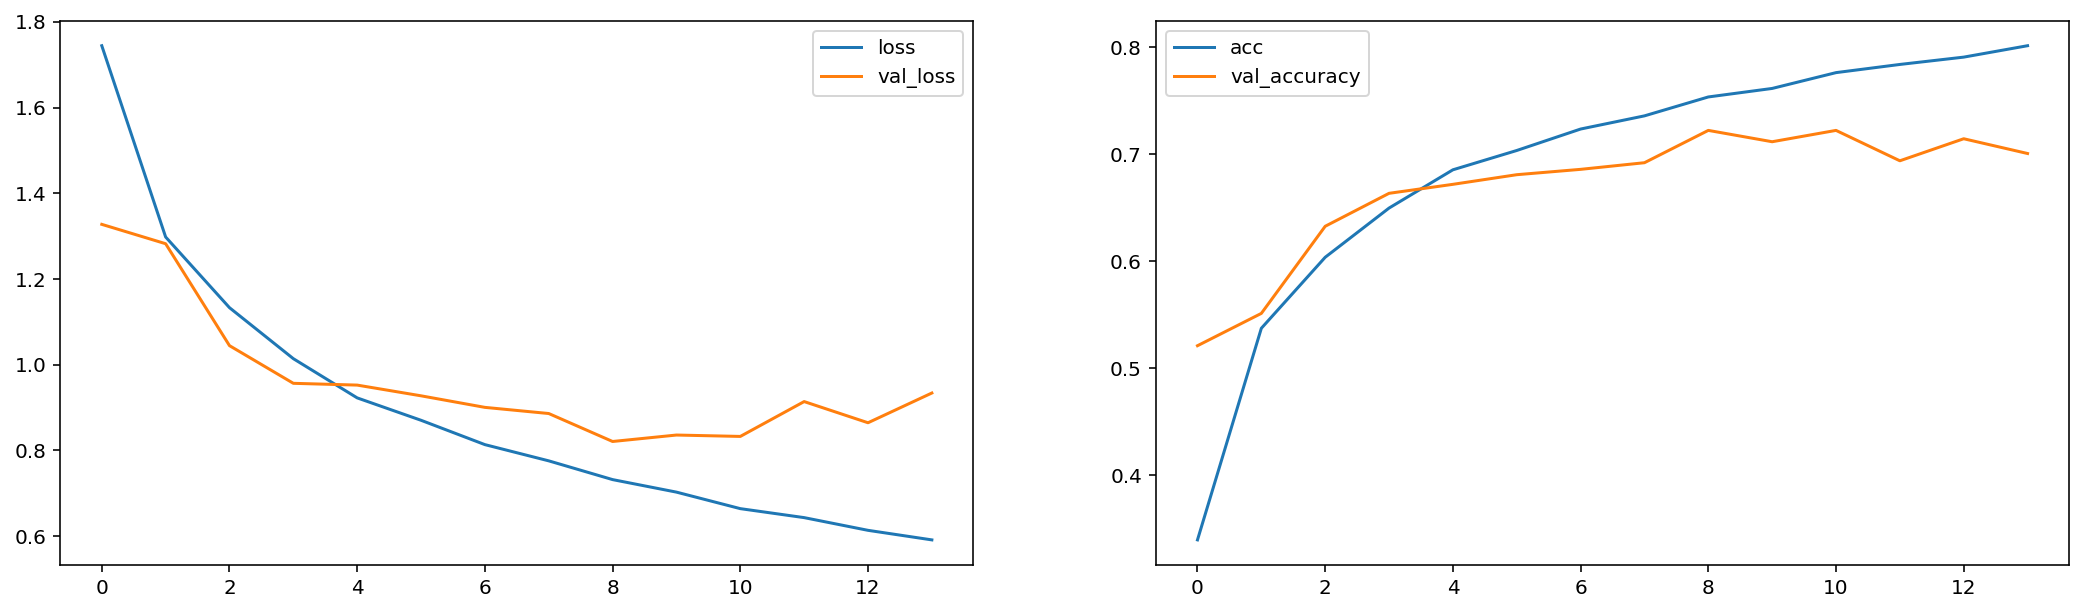

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18,5))
ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.legend()

ax2.plot(history.history['accuracy'], label="acc")
ax2.plot(history.history['val_accuracy'], label="val_accuracy")
ax2.legend()
plt.show();

In [14]:
model.load_weights('checkpoint.cifar10-cnn-tipo-VGG-16.hdf5')

In [15]:
def get_sorted_errors(model):
    losses = []
    for i in range(len(x_valid)):
        CE_loss = model.evaluate(x_valid[i:i+1], y_val_categorical[i:i+1], verbose=0)[0]
        losses.append(CE_loss)
    predictions = model.predict(x_valid)
    predicted_numbers = predictions.argmax(axis=1)
    sorted_loss_indexes = np.argsort(losses)[::-1]
    return predictions, predicted_numbers, sorted_loss_indexes

In [16]:
predictions, predicted_numbers, sorted_loss_indexes = get_sorted_errors(model)

In [17]:
from collections import Counter

In [23]:
errors_dict = Counter(list(zip(y_valid[sorted_loss_indexes], predicted_numbers[sorted_loss_indexes])))

TypeError: ignored

In [19]:
print(errors_dict.most_common()[10:])

NameError: ignored

In [22]:
sorted_loss_indexes

array([4516,  956, 1324, ..., 2456, 4264, 1603])